
# 🌋 Árbol de Decisión (Clasificación) con Datos Públicos USGS (Terremotos)
**API:** USGS Earthquakes (últimos 30 días)  
**Objetivo:** Clasificar si un sismo es **fuerte** (`mag ≥ 4.5`) usando características numéricas.  
Incluye **búsqueda de hiperparámetros**, **validación cruzada** y **métricas completas**.


In [1]:

import requests
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)


In [2]:

USGS_URL = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.geojson"

def fetch_usgs_earthquakes(url: str = USGS_URL) -> pd.DataFrame:
    """Descarga el GeoJSON de USGS y lo transforma a DataFrame.
    Devuelve columnas: [time_utc, place, mag, lon, lat, depth_km]."""
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    data = resp.json()
    rows = []
    for f in data.get("features", []):
        props = f.get("properties", {}) or {}
        geom  = f.get("geometry", {}) or {}
        coords = geom.get("coordinates", [None, None, None]) or [None, None, None]
        lon, lat, depth = None, None, None
        if isinstance(coords, (list, tuple)) and len(coords) >= 3:
            lon, lat, depth = coords[:3]
        # Convert ms to datetime
        t = props.get("time")
        t_utc = None
        if t is not None:
            t_utc = datetime.utcfromtimestamp(t/1000.0)
        rows.append({
            "time_utc": t_utc,
            "place": props.get("place"),
            "mag": props.get("mag"),
            "lon": lon, "lat": lat, "depth_km": depth
        })
    df = pd.DataFrame(rows)
    return df

def basic_clean(df: pd.DataFrame) -> pd.DataFrame:
    dfc = df.dropna(subset=["mag", "lon", "lat", "depth_km"]).copy()
    # Filtros razonables
    dfc = dfc[(dfc["mag"] >= -1) & (dfc["mag"] <= 10)]
    dfc = dfc[(dfc["lon"] >= -180) & (dfc["lon"] <= 180)]
    dfc = dfc[(dfc["lat"] >= -90) & (dfc["lat"] <= 90)]
    return dfc

def build_features_and_target(df: pd.DataFrame, mag_threshold: float = 4.5):
    X = df[["mag", "depth_km", "lon", "lat"]].copy()
    y = (df["mag"] >= mag_threshold).astype(int)  # 1 = fuerte
    return X, y


In [3]:

# --- Descarga y preparación ---
df_raw = fetch_usgs_earthquakes()
print("Filas descargadas:", len(df_raw))
df = basic_clean(df_raw)
X, y = build_features_and_target(df, mag_threshold=4.5)

print("Filas tras limpieza:", len(df))
print("Tasa de positivos (fuerte):", y.mean().round(4))
df.head()


Filas descargadas: 8324
Filas tras limpieza: 8208
Tasa de positivos (fuerte): 0.0693


C:\Users\User\AppData\Local\Temp\ipykernel_8700\3904698530.py:21: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  t_utc = datetime.utcfromtimestamp(t/1000.0)


,time_utc,place,mag,lon,lat,depth_km
0,2025-10-24 12:20:22.695,"66 km WNW of Tyonek, Alaska",0.60,-152.287700,61.289400,7.4000
1,2025-10-24 12:16:56.100,"5 km WNW of The Geysers, CA",1.05,-122.810997,38.792332,2.8700
2,2025-10-24 11:43:49.730,"6 km WNW of The Geysers, CA",1.32,-122.817665,38.798832,-0.6500
3,2025-10-24 11:33:50.430,"23 km ESE of Little Lake, CA",1.64,-117.669500,35.870500,5.0600
4,2025-10-24 11:24:35.250,"14 km SSW of Big Spring, Texas",1.20,-101.547000,32.132000,8.4229


In [4]:

# --- Partición estratificada ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((6566, 4), (1642, 4), 0.06929637526652452, 0.06942752740560293)

In [5]:

# --- Búsqueda de hiperparámetros ---
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [3, 5, 8, 12, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "class_weight": [None, "balanced"]
}

dt = DecisionTreeClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring="f1",   # puedes cambiar a 'roc_auc' si te interesa más AUC
    n_jobs=-1,
    cv=cv,
    verbose=1
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:")
print(grid.best_params_)
print("Mejor F1 (CV):", round(grid.best_score_, 4))

best_dt = grid.best_estimator_


Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Mejores hiperparámetros:
{'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor F1 (CV): 1.0


c:\Users\User\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [6]:

# --- Evaluación en test ---
y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1] if hasattr(best_dt, "predict_proba") else None

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, digits=4))


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
ROC AUC: 1.0000

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      1528
           1     1.0000    1.0000    1.0000       114

    accuracy                         1.0000      1642
   macro avg     1.0000    1.0000    1.0000      1642
weighted avg     1.0000    1.0000    1.0000      1642



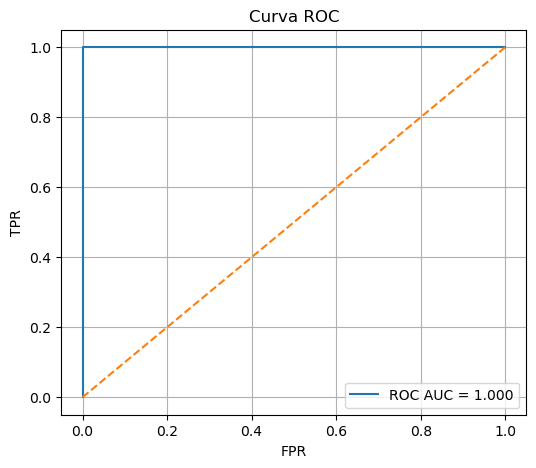

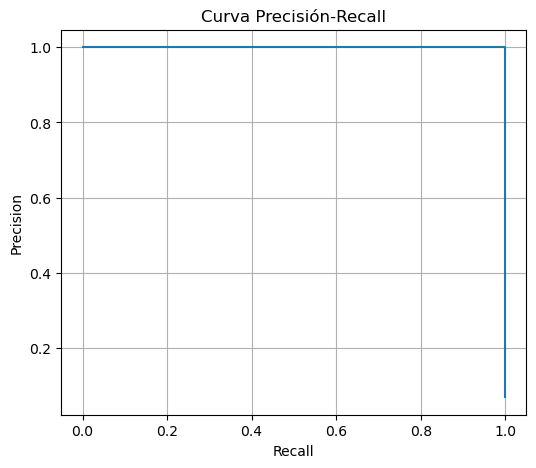

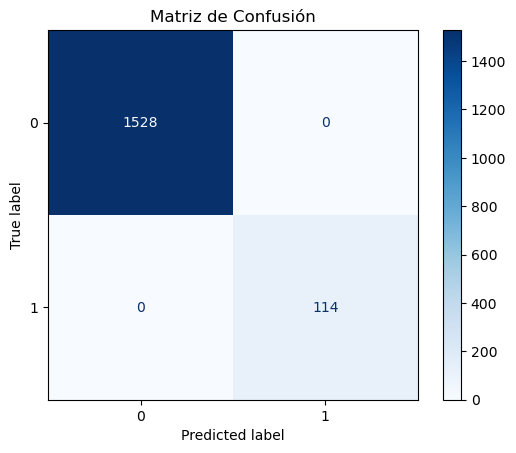

In [7]:

# --- Curva ROC & PR, Matriz de Confusión ---
if y_proba is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precs, recalls, _ = precision_recall_curve(y_test, y_proba)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.3f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Curva ROC")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,5))
    plt.plot(recalls, precs)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precisión-Recall")
    plt.grid(True)
    plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()


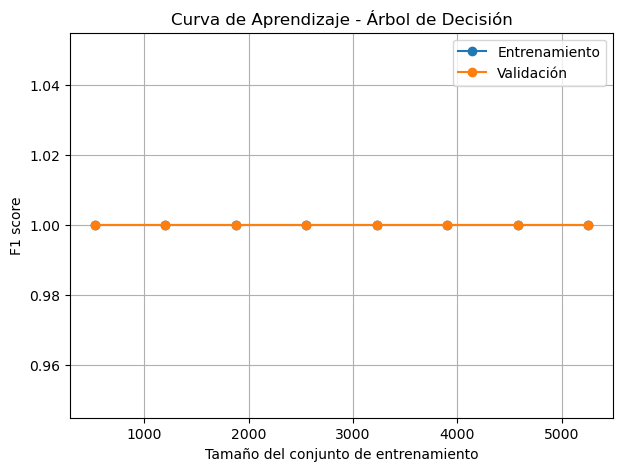

In [8]:

# --- Learning Curve (curva de aprendizaje) ---
train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train, y_train, cv=5, scoring="f1", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 8), shuffle=True, random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, marker="o", label="Entrenamiento")
plt.plot(train_sizes, val_mean, marker="o", label="Validación")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("F1 score")
plt.title("Curva de Aprendizaje - Árbol de Decisión")
plt.legend()
plt.grid(True)
plt.show()


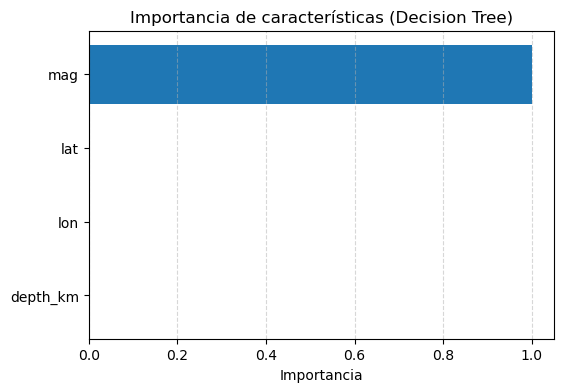

In [9]:

# --- Importancia de variables ---
importances = best_dt.feature_importances_
feat_names = X_train.columns

order = np.argsort(importances)
plt.figure(figsize=(6,4))
plt.barh(np.array(feat_names)[order], importances[order])
plt.xlabel("Importancia")
plt.title("Importancia de características (Decision Tree)")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()


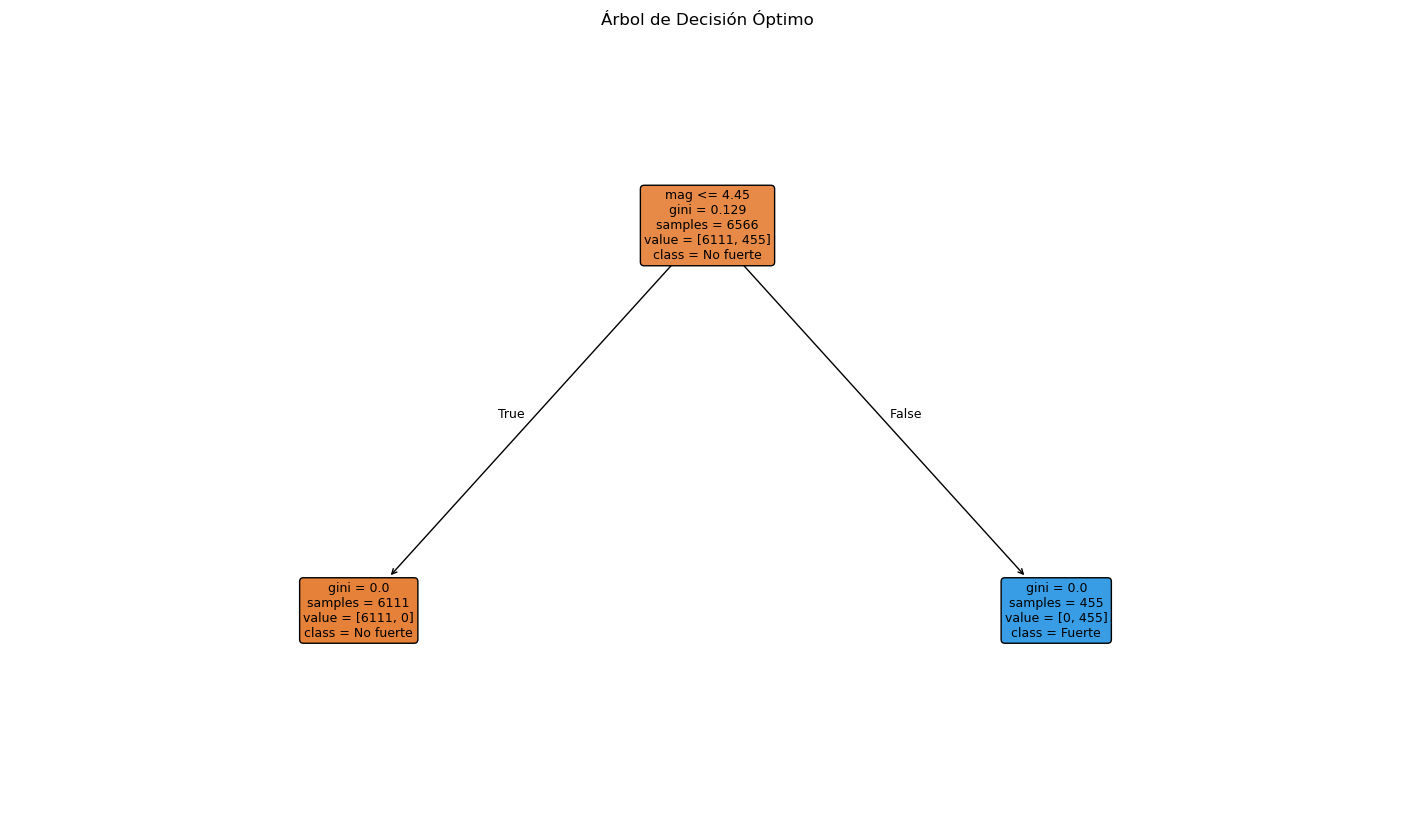

In [10]:

# --- Visualización del árbol ---
plt.figure(figsize=(18, 10))
plot_tree(
    best_dt,
    feature_names=X_train.columns,
    class_names=["No fuerte", "Fuerte"],
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title("Árbol de Decisión Óptimo")
plt.show()
